For each product image, I would like you to do the following. The output of this task will have the following variables for each image and append them to 
Read the image files and for each handbag image, find the below features and append it to ProductInfo.csv
1.	Logo size (logoSize)
2.	Logo contrast (logoConst)
3.	Logo conspicuousness (logoConsp)
4.	Number of colors (numColors)
5.	Color Entropy (ColorEnt)  


In [3]:
# Connecting to Google Cloud

from google.cloud import vision
from google.oauth2 import service_account

creds = service_account.Credentials.from_service_account_file('My First Project-c1dd0c0c9fd5.json')


In [4]:
import os
import io
import pandas as pd
import numpy as np
import cv2
import math
from math import log, e
import random
from PIL import Image as Img
from IPython.display import Image
import webcolors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import measure
from collections import Counter, defaultdict

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
def crop_image(img, img_path):
    '''
    This function takes a PIL image as an input and the image in bytes, detects handbag and returns the vertices of the handbag
    Input : PIL imaage and image in bytes
    Output : cropped handbag and its size
    
    content = cv2.imencode('.png', np.array(img))[1].tobytes()
    image = vision.Image(content=content) (converting pil to numpy detects very less logos)
    image = vision.Image(content=img_bytes) # directly using img bytes (doesn't detect all logos)
    '''

    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
          
    height, width = img.size

    objects = client.object_localization(image=image).localized_object_annotations

    cropped_imgs = []
    for object_ in objects:
        if object_.name =='Bag' or object_.name == 'handbag':
            vects = object_.bounding_poly.normalized_vertices
            
            x0, x2 = vects[0].x, vects[2].x
            x0, x2 = x0*width, x2*width
            y0, y2 = vects[0].y, vects[2].y
            y0, y2 = y0*height, y2*height
            
            vects = [x0, y0, x2-1, y2-1]
            
            crop_img = img.crop(vects)
            cropped_imgs.append(crop_img)
    
    if len(cropped_imgs) > 0:
        cropped_imgs[0].save('cropped.jpg')
        return cropped_imgs[0]
    else:
        img.save('cropped.jpg')
        return img


def get_logo(bag_img, img_path):
    '''
     This functions takes cropped handbag image in PIL format, detects logo and returns the cropped logo
     Input: Cropped handbag image in PIL
     Output: Cropped logo and its size if logo exists else None, 0
     
     #content = cv2.imencode('.png', np.array(bag_img))[1].tobytes()
     #image = vision.Image(content=content)
     #image = vision.Image(content=cropped_img_bytes)
    '''
    
    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
        
    # Detects logo and returns the size of the logo and vertices  
    response = client.logo_detection(image=image)
    annotations = response.logo_annotations
    #print("Annotations  in logo vertices func : ", annotations)
    if len(annotations) != 0:
        for annotation in annotations:
            vects = annotation.bounding_poly.vertices
            #print(vects)
    else:
        vects = []
        
    if len(vects) > 0: 
        cropped_logo = bag_img.crop([vects[0].x, vects[0].y, vects[2].x - 1, vects[2].y - 1]) 
        #Img.fromarray(np.array(cropped_logo)).show()
        #print("Logo found")
        return cropped_logo
    else:
        return None
        
    

def closest_color(requested_color):
    '''
     This functions takes a color in rgb and returns the color that closely resembles to that color
     Input: Color
     Output: color closest to the minimum color
    '''

    min_colors = {}
    for key, name in webcolors.css21_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
        
    return min_colors[min(min_colors.keys())]



def get_color_name(requested_color):
    '''
     This functions takes a color in rgb and returns the name of the color.
     Input: Color
     Output: Name of the color
    '''

    try:
        actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name = closest_color(requested_color)
        actual_name = None
        
    return actual_name, closest_name


def centroid_histogram(clt):
    '''
     This functions takes the labels from the kmeans model and creates a histogram
     Input: fitted model
     Output: creates a histogram of all the colors based on labels
    '''
    # grab the number of different clusters based on the number of pixels assigned to each cluster

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist



def get_most_dominant_color(bar):
    '''
     This functions takes all the colors and returns the most dominant color, ratio and rgb_color
     Input: all the colors
     Output: Most dominant color with its ratio and rgb value
    '''

    dominant_color = "black"
    max_ratio = 0

    for colors in bar:
        if colors[1] > max_ratio:
            max_ratio = colors[1]
            dominant_color = colors[0]
            rgb_color = colors[2]
        
    return dominant_color, max_ratio, rgb_color  



def get_sorted_colors(all_colors):
    '''
     This functions takes all the colors which can be duplicate and returns the list of unique colors in
     decending order based on their total ratio
     Input: all the colors
     Output: list of unoque colors in decending order
    '''
    
    color_pixels = {}

    for color in all_colors:
        if color[0] not in color_pixels:
            color_pixels[color[0]] = color[1]
        else:
            color_pixels[color[0]] += color[1]

    sorted_colors_pixels = sorted(color_pixels.items(), key=lambda x: x[1], reverse=True) 
    
    return sorted_colors_pixels



def get_colors(hist, centroids):
    '''
     This functions takes the histogram and labels and returns dominant color, it's ratio, rgb value and all colors
     Input: histogram and labels
     Output: dominant_color, ratio, rgb_color, all_colors
    '''
    
    # initialize the bar chart representing the relative frequency of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    all_colors = []
    
    # loop over the percentage and color of each cluster
    for (percent, color) in zip(hist, centroids):
        requested_color = color.astype(int)
        
        actual_name, closest_name = get_color_name(requested_color)
        
        if actual_name is None:
            all_colors.append([closest_name, percent, requested_color])
        else:
            all_colors.append([actual_name, percent, requested_color])
            
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX
         
    dominant_color, ratio, rgb_color = get_most_dominant_color(all_colors)

    return bar, dominant_color, ratio, rgb_color, all_colors



def mean_image(image, segments):
    '''
    This function takes segmented image and number of segments as input and returns the image with
    average of superpixels
    Input: Segmented Image, No of segments
    Output: Image with average of colors in superpixels
    '''

    reshaped_image = image.reshape((image.shape[0]*image.shape[1], image.shape[2]))
    segment_1d = np.reshape(segments, -1)    
    unique_segment = np.unique(segment_1d)
    img_shape = np.zeros(reshaped_image.shape)
    
    for i in unique_segment:
        loc = np.where(segment_1d==i)[0]
        img_mean = np.mean(reshaped_image[loc,:], axis=0)
        img_shape[loc,:] = img_mean
        
    out_img = np.reshape(img_shape,[image.shape[0], image.shape[1], image.shape[2]]).astype('uint8')
    
    return out_img 
    


def segment_image(cropped_img, numSegments):
    '''
    Segements the cropped image as input and no of segments and convert it into superpixels
    Input: Cropped Image, Number of segments
    Output: Segmented image and image with average of colors in superpixels
    '''

    converted_img = img_as_float(cropped_img[:,:,::-1]) #convert it to a floating point data type
    segments = slic(converted_img, n_segments=numSegments, compactness=10, sigma=5, convert2lab=True)
    
    # Average the color in each superpixel.
    out_img = mean_image(cropped_img, segments)
    
    return out_img



def is_white_pixel(x):
    x = x.tolist()
    if x[0]==x[1]==x[2]==255:
        return False
    return True


def segment_and_cluster(num_segments, cropped_img, cluster_size):
    '''
    This function segments the image, cluster the pixels using kmeans clustering and return the complete details of colors
    Input: number of segments to be done, cropped image, cluster size
    Output: bar, dominant_color, ratio, rgb_color, all_colors
    '''
    
    # Segmentation of the image into superpixels and taking average of superpixels
    out_img = segment_image(cropped_img, num_segments)
    
    # Removing the white background before clustering
    reshaped_img = out_img.reshape((-1,3))
    mask = np.apply_along_axis(is_white_pixel, 1, reshaped_img)
    white_removed = reshaped_img[mask]
    
    # cluster the pixel intensities   
    clt = KMeans(n_clusters = cluster_size, random_state=42)
    clt.fit(white_removed)
    #clt.fit(filtered_img.reshape(-1,3))
    

    hist = centroid_histogram(clt)   
    bar, dominant_color, ratio, rgb_color, all_colors = get_colors(hist, clt.cluster_centers_)
    
    #plt.figure()
    #plt.axis("off")
    #plt.imshow(bar)
    #plt.show()
    
    
    return bar, dominant_color, ratio, rgb_color, all_colors
   
    
    
def calculate_luminace(color_code):
    '''
    This function calculates the luminance of color
    Input: a color code in rgb
    Output: luminance
    '''
    
    index = float(color_code)/255 

    if index < 0.03928:
        return index / 12.92
    else:
        return ((index + 0.055) / 1.055)**2.4
    

    
def calculate_relative_luminance(rgb):
    '''
    This function calculates the relative luminance of the color using the 3 channels of R, G, B
    Input: a color in rgb
    Output: relative luminance
    '''
    
    return 0.2126*calculate_luminace(rgb[0]) + 0.7152*calculate_luminace(rgb[1]) + 0.0722*calculate_luminace(rgb[2])
    


def mask_background(img):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lower_white = np.array([254, 254, 254], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(img, lower_white, upper_white)  # could also use threshold
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))  # "erase" the small white points in the resulting mask
    mask = cv2.bitwise_not(mask)  # invert mask

    # load background (could be an image too)
    bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk

    # get masked foreground
    fg_masked = cv2.bitwise_and(img, img, mask=mask)

    return fg_masked



def remove_glare(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = mask_background(new_img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9,9), 0 )
    
    _,thresh_img = cv2.threshold( blurred, 180, 255, cv2.THRESH_BINARY)
    thresh_img = cv2.erode( thresh_img, None, iterations=1)
    thresh_img  = cv2.dilate( thresh_img, None, iterations=5)
    
    # perform a connected component analysis on the thresholded image,
    # then initialize a mask to store only the "large" components
    labels = measure.label( thresh_img, neighbors=8, background=0 )
    mask = np.zeros( thresh_img.shape, dtype="uint8" )
    
    for label in np.unique( labels ):
        if label == 0:
            continue
            
        # otherwise, construct the label mask and count the number of pixels
        labelMask = np.zeros( thresh_img.shape, dtype="uint8" )
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero( labelMask )
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 500:
            mask = cv2.add( mask, labelMask )
            
    # Masking   
    flag = cv2.INPAINT_NS
    #flag2 = cv2.INPAINT_TELEA
    #new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    output = cv2.inpaint(new_img, mask, 3, flags=flag)
  
    return output[:,:,::-1]

Total sellers :  114


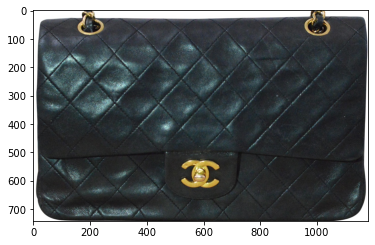

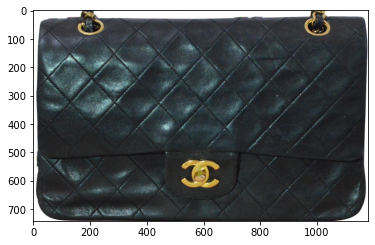

Color result dict :  {1: [('teal', 1.0)], 2: [('black', 0.9180453770503776), ('silver', 0.08195462294962239)], 3: [('black', 0.8230746934276083), ('gray', 0.10904117530257834), ('silver', 0.06788413126981338)]}
k2_dominant_ratio :  0.9180453770503776
Total colors are :  1
Entropy of handbag is :  0


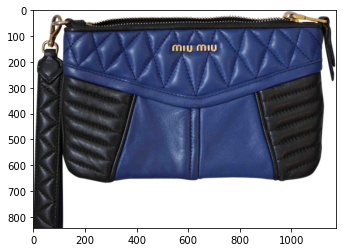

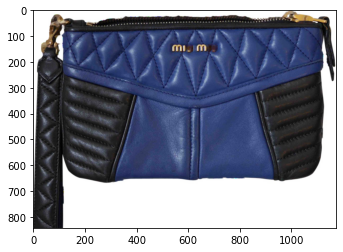

Color result dict :  {1: [('gray', 1.0)], 2: [('navy', 0.8566749359243405), ('white', 0.14332506407565948)], 3: [('teal', 0.5206886666819875), ('black', 0.335986269242353), ('white', 0.14332506407565948)]}
k2_dominant_ratio :  0.8566749359243405
Total colors are :  2
Entropy of handbag is :  0.5928810487199951


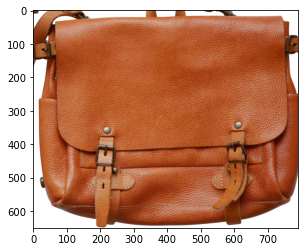

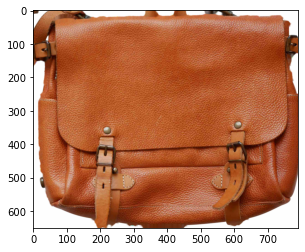

Color result dict :  {1: [('gray', 1.0)], 2: [('olive', 0.9074203574203574), ('white', 0.09257964257964257)], 3: [('olive', 0.9157867132867132), ('white', 0.08421328671328672)]}
k2_dominant_ratio :  0.9074203574203574
Total colors are :  1
Entropy of handbag is :  0


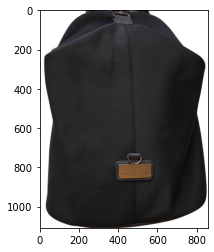

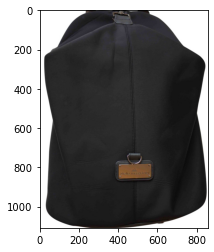

Color result dict :  {1: [('black', 1.0)], 2: [('black', 0.8871252558047356), ('white', 0.11287474419526447)], 3: [('black', 0.8364764748715687), ('white', 0.10350321662625007), ('gray', 0.06002030850218116)]}
k2_dominant_ratio :  0.8871252558047356
Total colors are :  2
Entropy of handbag is :  0.5085266210916541


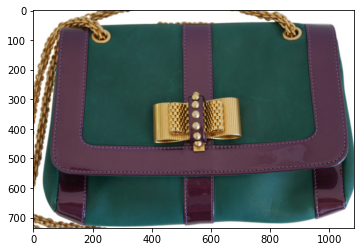

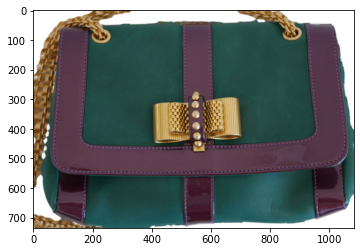

Color result dict :  {1: [('gray', 1.0)], 2: [('teal', 0.8886799891986323), ('white', 0.11132001080136766)], 3: [('teal', 0.785876831446686), ('gray', 0.12459986130638231), ('white', 0.0895233072469317)]}
k2_dominant_ratio :  0.8886799891986323
Total colors are :  2
Entropy of handbag is :  0.503884715296731


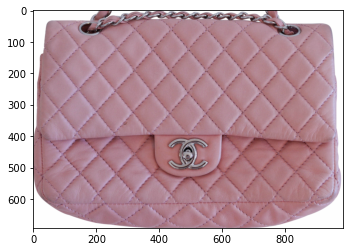

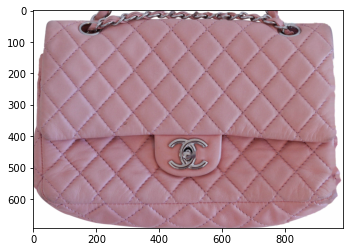

Color result dict :  {1: [('gray', 1.0)], 2: [('gray', 0.9053578240075115), ('white', 0.09464217599248849)], 3: [('gray', 0.9062498166133623), ('white', 0.09375018338663772)]}
k2_dominant_ratio :  0.9053578240075115
Total colors are :  1
Entropy of handbag is :  0


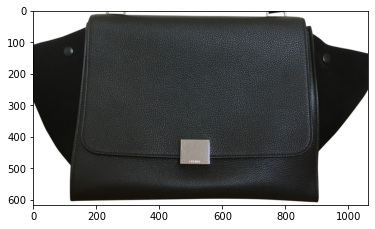

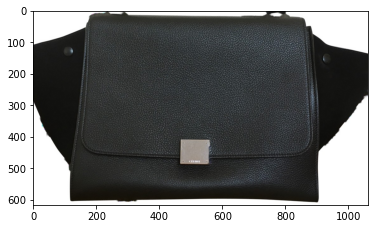

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.8943986817635481), ('white', 0.10560131823645189)], 3: [('black', 0.8555178265373068), ('white', 0.09311401151761632), ('gray', 0.05136816194507687)]}
k2_dominant_ratio :  0.8943986817635481
Total colors are :  2
Entropy of handbag is :  0.4865039432348396


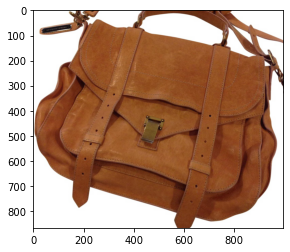

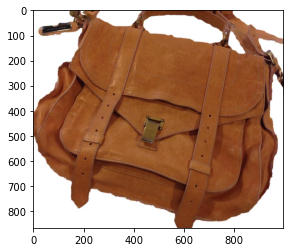

Color result dict :  {1: [('gray', 1.0)], 2: [('olive', 0.8250136765847942), ('white', 0.1749863234152058)], 3: [('olive', 0.5260020887874959), ('maroon', 0.29901158779729836), ('white', 0.1749863234152058)]}
k2_dominant_ratio :  0.8250136765847942
Total colors are :  2
Entropy of handbag is :  0.6689852390657071


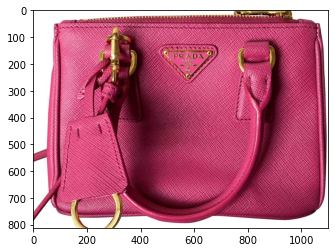

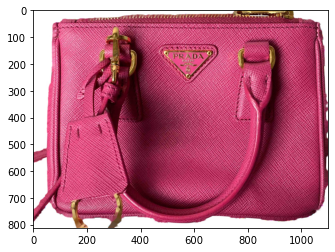

Color result dict :  {1: [('gray', 1.0)], 2: [('purple', 0.8973879358305421), ('white', 0.10261206416945792)], 3: [('gray', 0.6495062743113826), ('maroon', 0.2509106394279971), ('white', 0.0995830862606203)]}
k2_dominant_ratio :  0.8973879358305421
Total colors are :  2
Entropy of handbag is :  0.47722137363151984


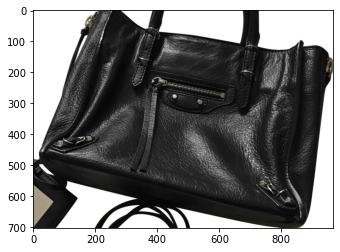

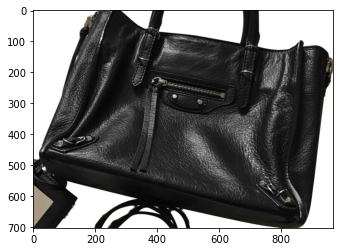

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.8296627468097671), ('white', 0.17033725319023288)], 3: [('black', 0.6226105348293836), ('gray', 0.2138338639689835), ('white', 0.16355560120163298)]}
k2_dominant_ratio :  0.8296627468097671
Total colors are :  2
Entropy of handbag is :  0.6584756900794272


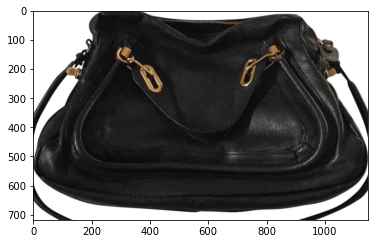

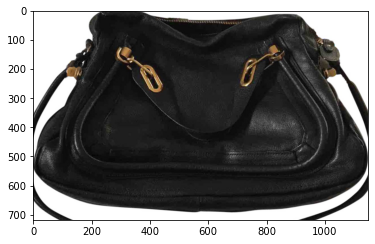

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.8419258611600426), ('white', 0.1580741388399573)], 3: [('black', 0.7411196687796536), ('white', 0.1562033096318774), ('gray', 0.102677021588469)]}
k2_dominant_ratio :  0.8419258611600426
Total colors are :  2
Entropy of handbag is :  0.6296823118536223


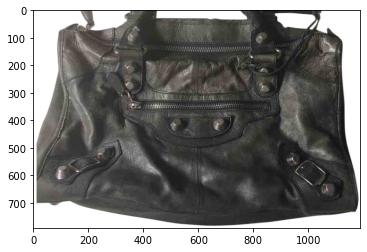

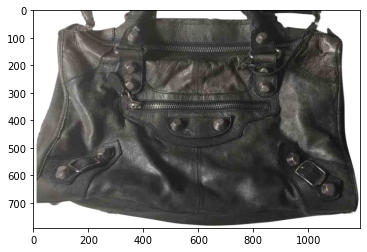

Color result dict :  {1: [('gray', 1.0)], 2: [('gray', 0.8814294382238821), ('white', 0.11857056177611797)], 3: [('black', 0.6271625503484933), ('gray', 0.25426688787538876), ('white', 0.11857056177611797)]}
k2_dominant_ratio :  0.8814294382238821
Total colors are :  2
Entropy of handbag is :  0.5252379834787659


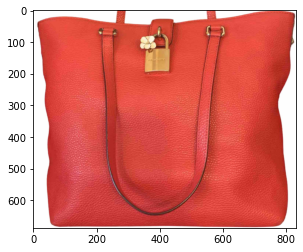

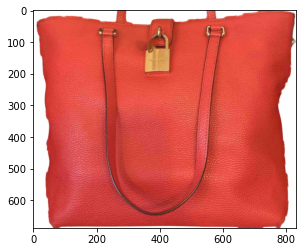

Color result dict :  {1: [('gray', 1.0)], 2: [('red', 0.8850171902951699), ('white', 0.11498280970483005)], 3: [('red', 0.8886823568872988), ('white', 0.11131764311270126)]}
k2_dominant_ratio :  0.8850171902951699
Total colors are :  2
Entropy of handbag is :  0.5147650419317997


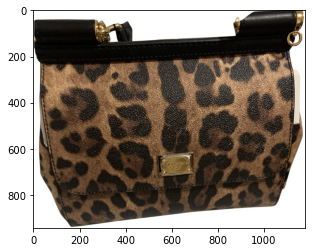

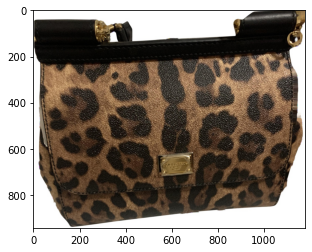

Color result dict :  {1: [('gray', 1.0)], 2: [('maroon', 0.8610763285804688), ('white', 0.1389236714195312)], 3: [('black', 0.5108646520368457), ('gray', 0.3552097819375761), ('white', 0.13392556602557815)]}
k2_dominant_ratio :  0.8610763285804688
Total colors are :  2
Entropy of handbag is :  0.5814130484171477


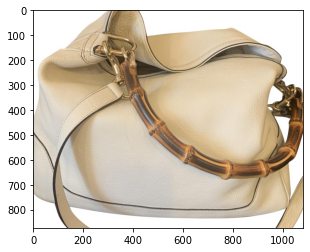

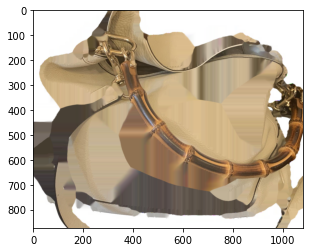

Color result dict :  {1: [('gray', 1.0)], 2: [('silver', 0.5867116519395283), ('gray', 0.41328834806047166)], 3: [('silver', 0.4783281447959624), ('gray', 0.35888832221394007), ('white', 0.16278353299009754)]}
k2_dominant_ratio :  0.5867116519395283
Total colors are :  3
Entropy of handbag is :  1.4658101814534357


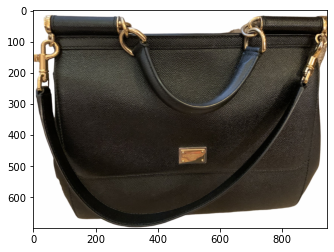

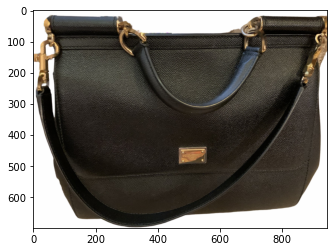

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.7941273193543521), ('white', 0.2058726806456479)], 3: [('black', 0.5846341831347112), ('gray', 0.2227349524815206), ('white', 0.19263086438376828)]}
k2_dominant_ratio :  0.7941273193543521
Total colors are :  2
Entropy of handbag is :  0.7335190915852334


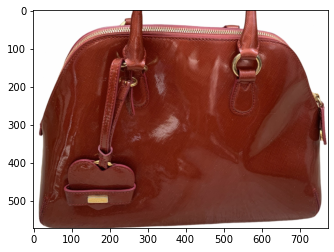

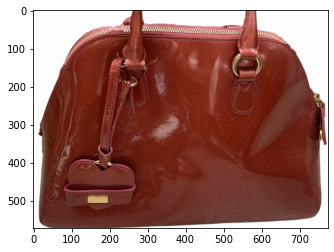

Color result dict :  {1: [('gray', 1.0)], 2: [('maroon', 0.8043132578016299), ('white', 0.1956867421983701)], 3: [('maroon', 0.7344554670136065), ('white', 0.18078368659764008), ('gray', 0.08476084638875336)]}
k2_dominant_ratio :  0.8043132578016299
Total colors are :  2
Entropy of handbag is :  0.7132172461597966


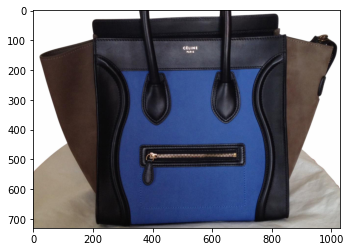

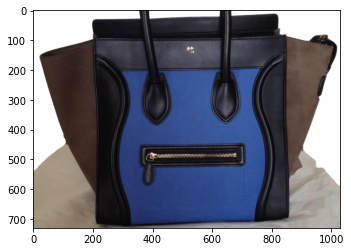

Color result dict :  {1: [('gray', 1.0)], 2: [('navy', 0.7465474132198431), ('silver', 0.2534525867801569)], 3: [('black', 0.41565234738662055), ('gray', 0.3968599547812209), ('white', 0.18748769783215855)]}
k2_dominant_ratio :  0.7465474132198431
Total colors are :  2
Entropy of handbag is :  0.8167046248195363


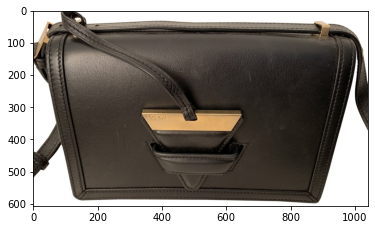

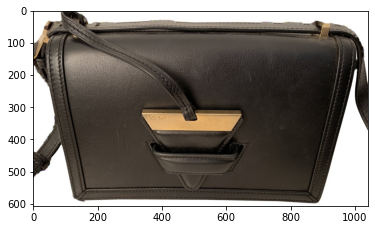

Color result dict :  {1: [('gray', 1.0)], 2: [('maroon', 0.8265120463860842), ('white', 0.17348795361391584)], 3: [('black', 0.7217384784564631), ('gray', 0.14341697490752775), ('white', 0.1348445466360092)]}
k2_dominant_ratio :  0.8265120463860842
Total colors are :  2
Entropy of handbag is :  0.6656218789146461


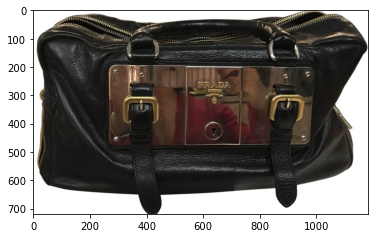

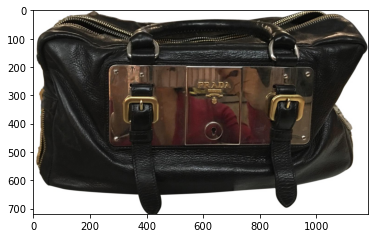

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.849559551455767), ('white', 0.150440448544233)], 3: [('black', 0.6182521674021201), ('gray', 0.23529694961035538), ('white', 0.14645088298752454)]}
k2_dominant_ratio :  0.849559551455767
Total colors are :  2
Entropy of handbag is :  0.6109414306806475


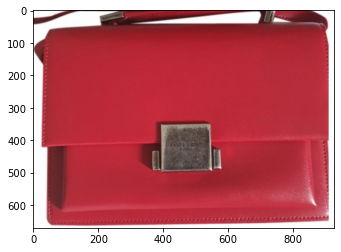

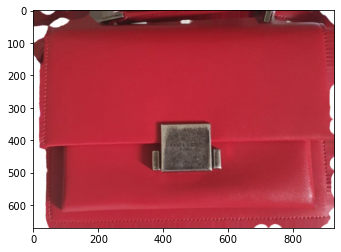

Color result dict :  {1: [('purple', 1.0)], 2: [('maroon', 0.9601341353576943), ('white', 0.03986586464230571)], 3: [('maroon', 0.9601341353576942), ('white', 0.03986586464230571)]}
k2_dominant_ratio :  0.9601341353576943
Total colors are :  1
Entropy of handbag is :  0


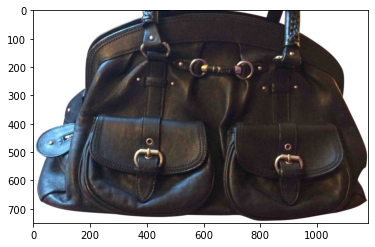

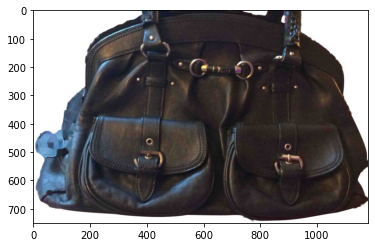

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.8996092667200808), ('white', 0.1003907332799192)], 3: [('black', 0.7067778997105257), ('gray', 0.19422367866459592), ('white', 0.09899842162487833)]}
k2_dominant_ratio :  0.8996092667200808
Total colors are :  2
Entropy of handbag is :  0.47023296653021607


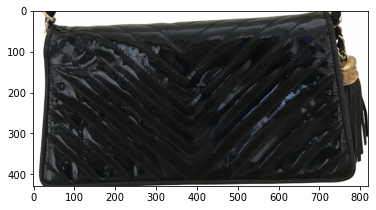

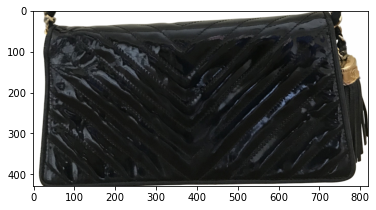

Color result dict :  {1: [('black', 1.0)], 2: [('black', 0.875245892319063), ('white', 0.12475410768093695)], 3: [('black', 0.740556597873671), ('gray', 0.13683267951560635), ('white', 0.12261072261072262)]}
k2_dominant_ratio :  0.875245892319063
Total colors are :  2
Entropy of handbag is :  0.5428737371986095


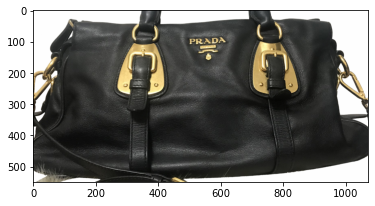

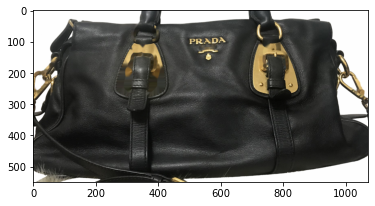

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.8075786357301338), ('white', 0.19242136426986625)], 3: [('black', 0.762920636860716), ('white', 0.15469285000093366), ('gray', 0.08238651313835034)]}
k2_dominant_ratio :  0.8075786357301338
Total colors are :  2
Entropy of handbag is :  0.7065093744060406


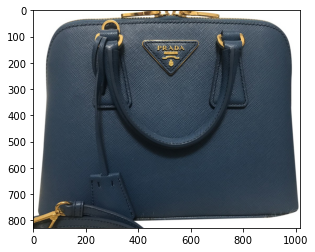

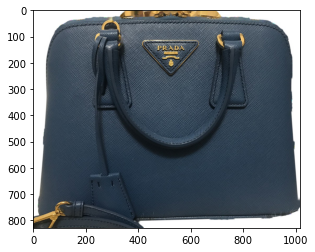

Color result dict :  {1: [('gray', 1.0)], 2: [('teal', 0.8810994493317462), ('white', 0.11890055066825383)], 3: [('navy', 0.6631403091097369), ('gray', 0.22422069312584075), ('white', 0.11263899776442238)]}
k2_dominant_ratio :  0.8810994493317462
Total colors are :  2
Entropy of handbag is :  0.5261922530883016


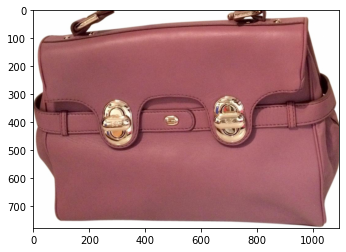

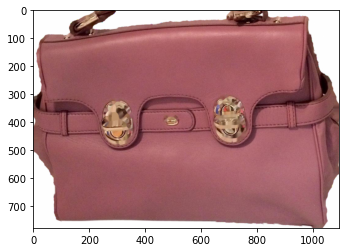

Color result dict :  {1: [('gray', 1.0)], 2: [('gray', 0.8670452996714964), ('white', 0.13295470032850368)], 3: [('gray', 0.7800317694552666), ('white', 0.13295470032850368), ('maroon', 0.08701353021622968)]}
k2_dominant_ratio :  0.8670452996714964
Total colors are :  2
Entropy of handbag is :  0.565486135296954


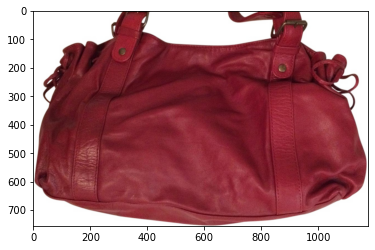

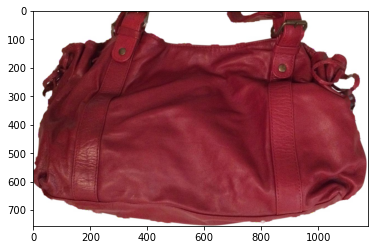

Color result dict :  {1: [('gray', 1.0)], 2: [('maroon', 0.8510867726657646), ('white', 0.14891322733423545)], 3: [('maroon', 0.4616719235055321), ('purple', 0.38941484916023245), ('white', 0.14891322733423545)]}
k2_dominant_ratio :  0.8510867726657646
Total colors are :  2
Entropy of handbag is :  0.6071139603287554


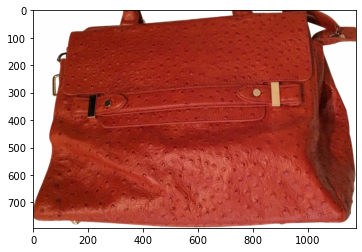

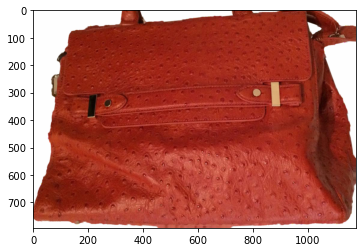

Color result dict :  {1: [('olive', 1.0)], 2: [('maroon', 0.8689973437793459), ('white', 0.13100265622065413)], 3: [('maroon', 0.6200037562716321), ('olive', 0.25167127257116795), ('white', 0.12832497115719996)]}
k2_dominant_ratio :  0.8689973437793459
Total colors are :  2
Entropy of handbag is :  0.5601815755771533


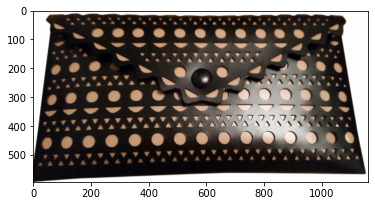

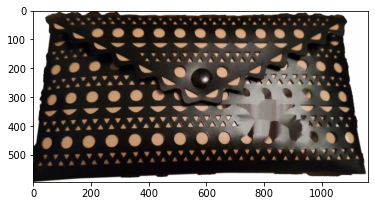

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.7406319874020132), ('silver', 0.25936801259798675)], 3: [('black', 0.6736515311020048), ('gray', 0.220370515374822), ('white', 0.10597795352317316)]}
k2_dominant_ratio :  0.7406319874020132
Total colors are :  2
Entropy of handbag is :  0.8257911966260406


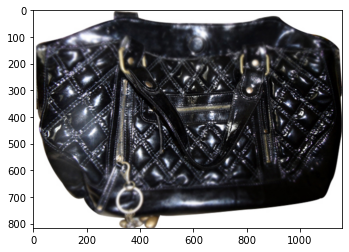

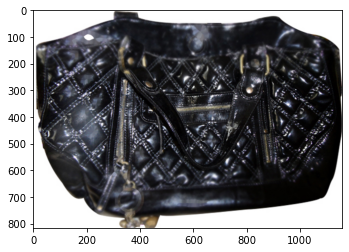

Color result dict :  {1: [('gray', 1.0)], 2: [('black', 0.8526263229454493), ('white', 0.14737367705455073)], 3: [('black', 0.6435866033744597), ('gray', 0.22644732565684783), ('white', 0.1299660709686924)]}
k2_dominant_ratio :  0.8526263229454493
Total colors are :  2
Entropy of handbag is :  0.6032287174717692


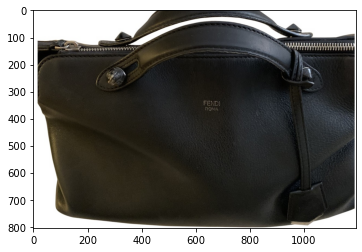

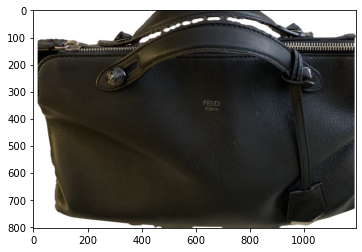

Color result dict :  {1: [('black', 1.0)], 2: [('black', 0.8974848673343223), ('white', 0.10251513266567769)], 3: [('black', 0.7930839591010809), ('gray', 0.10440090823324147), ('white', 0.10251513266567769)]}
k2_dominant_ratio :  0.8974848673343223
Total colors are :  2
Entropy of handbag is :  0.4769180467518506


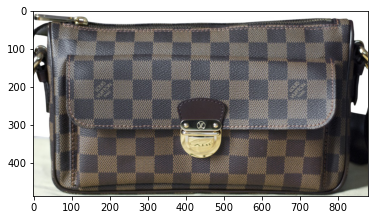

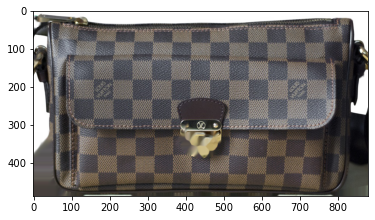

Color result dict :  {1: [('gray', 1.0)], 2: [('gray', 0.9099667664146965), ('white', 0.09003323358530348)], 3: [('gray', 0.5006925633352716), ('black', 0.41630383911730084), ('white', 0.08300359754742759)]}
k2_dominant_ratio :  0.9099667664146965
Total colors are :  1
Entropy of handbag is :  0


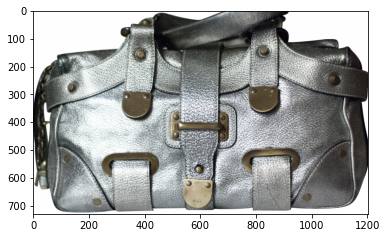

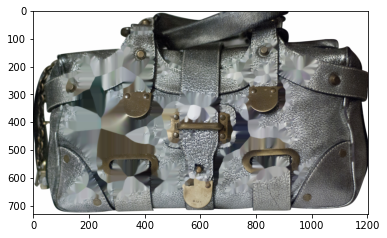

Color result dict :  {1: [('gray', 1.0)], 2: [('gray', 0.5206935784826833), ('silver', 0.4793064215173167)], 3: [('gray', 0.8489145769808402), ('white', 0.15108542301915986)]}
k2_dominant_ratio :  0.5206935784826833


IndexError: list index out of range

In [7]:
def process_images(img_path):
    
    if not os.path.isfile(img_path):
        return pd.Series([None]*5)
    
    # Get the cropped bag
    img = Img.open(img_path)
    cropped_bag = crop_image(img, img_path) 
    height, width = cropped_bag.size
    bag_size = height*width
    #print("Bag size : ", bag_size)
    #Img.fromarray(np.array(cropped_bag)).show()
    
    # Get the cropped logo
    cropped_img_path = 'cropped.jpg'
    cropped_img = Img.open(cropped_img_path)
    cropped_logo= get_logo(cropped_img, cropped_img_path) 
    

    # converting cropped bag img from PIL to numpy array
    cropped_bag = np.array(cropped_bag)
    plt.imshow(cropped_bag)
    plt.show()
    
    # Removing glares from the image
    cropped_bag = remove_glare(cropped_bag)
    plt.imshow(cropped_bag)
    plt.show()

    # Segmentation of the image into superpixels, taking average of superpixels and then doing clustering
    num_segments = 600
    cluster_size = 4

    color_result = {}
    rgb_colors = []
    for i in range(1, cluster_size):
        # print("Processing for bag")
        bar, bag_dominant_color, bag_ratio, bag_rgb, all_bag_colors = segment_and_cluster(num_segments, cropped_bag, i)
        sorted_bag_colors = get_sorted_colors(all_bag_colors)
        color_result[i] = sorted_bag_colors
        rgb_colors.append(bag_rgb)


    #print("Processing for logo")
    
    if cropped_logo is not None:
        cropped_logo = np.array(cropped_logo)  # converting pil image to numpy array
        num_segments = 300
        cluster_size = 1

        # Get logo size 
        height, width, _ = cropped_logo.shape
        logo_size = height * width
        #print("Logo size : ", logo_size)        
        
        bar, logo_dominant_color, logo_ratio, logo_rgb, all_logo_colors = segment_and_cluster(num_segments, cropped_logo, cluster_size)
        sorted_logo_colors = get_sorted_colors(all_logo_colors)
        #print("logo colors : ", sorted_logo_colors)

        # Calculate contrast ratio of logo to bag
        contrast_ratio = (calculate_relative_luminance(logo_rgb)+0.05) / (calculate_relative_luminance(bag_rgb)+0.05)
        #print("Contrast ratio is : ", contrast_ratio)
        
        # Calculate Logo Conspicuousness
        relative_size = logo_size/bag_size
        logo_conspicuousness = contrast_ratio * relative_size
        #print("Logo Conspicuousness : ", logo_conspicuousness)

    else:
        logo_size = 0.0
        contrast_ratio = 0.0
        logo_conspicuousness = 0.0
        
        

    # Find total number of colors and entropy of the bag

    print("Color result dict : ", color_result)
    k2 = color_result[2]
    k3 = color_result[3]
    k2_dominant_ratio = k2[0][1]
    print("k2_dominant_ratio : ", k2_dominant_ratio)
    if k2_dominant_ratio >= 0.9: 
        total_colors = 1
        entropy = 0
    elif k2_dominant_ratio < 0.9 and k2_dominant_ratio >= 0.6:
        total_colors = 2
        entropy = -1 * ((k2_dominant_ratio * log(k2_dominant_ratio, 2)) + (k2[1][1] * log(k2[1][1], 2)))
    else:
        total_colors = 3
        entropy = -1 * ((k3[0][1] * log(k3[0][1], 2) + (k3[1][1] * log(k3[1][1], 2)) +
                       (k3[2][1] * log(k3[2][1], 2))))
                
    print("Total colors are : ", total_colors)
    print("Entropy of handbag is : ", entropy)
    
    return_output = (logo_size,
                     round(contrast_ratio, 3),
                     round(logo_conspicuousness, 3),
                     total_colors, round(entropy, 3))

    for i in range(1, 4):
        colors, ratios = list(zip(*color_result[i]))
        ratios = [round(val, 2) for val in ratios]
        return_output = return_output + (colors, ratios)

    return pd.Series(return_output)


def read_images(dir_path, client):
    count = 0
    
    item_details = pd.DataFrame(columns = ['Seller', 'Item ID', 'category', 'brand', 'color', 'Image_path']) 
    dir_names = os.listdir(dir_path)
    print("Total sellers : ", len(dir_names))
    for seller in dir_names:
        if not seller.startswith('seller_'):
            continue
        
        product_info = pd.read_csv(dir_path+seller+'/ProductInfo.csv', usecols=["Item ID", "category", "brand", "color"])
        product_info['Seller'] = seller

        
        # Get the image names and add to the dataframe
        product_info['Image_path'] = ''
        img_fnames = os.listdir(dir_path + seller + '/Images')
        for idx in range(len(img_fnames)):
            img_path = dir_path + seller + '/Images/' + img_fnames[idx]
            img_id = int(img_fnames[idx].split('-')[0])
            img_fnames[idx] =  [img_path, img_id]
        
        img_ids, img_names = map(list, zip(*img_fnames))
        product_info['Image_path'] = product_info['Item ID'].replace(to_replace=img_names, value=img_ids)
        
        item_details = pd.concat([item_details, product_info], ignore_index=True)
        
    
    # Removing the rows that doesn't contain bags
    item_details = item_details[item_details['category'].str.match('Bags')]
    
    #import ipdb; ipdb.set_trace()
    
    new_cols = ['Logo Size', 'Logo Contrast', 'Logo Conspicuousness', 'Number of colors', 'Color Entropy']
    for col in new_cols:
        item_details[col] = None
    
    #item_details = item_details.head()    
    item_details[new_cols] = item_details['Image_path'].apply(process_images)
    
    return item_details

client = vision.ImageAnnotatorClient(credentials=creds)
product_info = read_images('Group4/Sellers/', client) #seller_105548/Images')
product_info

In [15]:
product_info.to_csv("bag_details.csv")

### Getting unique handbag brands:

In [15]:
bags = pd.read_csv("bag_details_v1.csv")
bag_brands = bags['brand']
bag_brands.value_counts().to_csv("bag_brands.csv")

### Checking and removing the glare part in the images

In [18]:
# Finding the bags with 3 colors to check accuracy:

bags = pd.read_csv("bag_details_v2.csv")
print(bags.columns)

rel_bags = bags[bags['Number of colors']==3.0]
rel_bags
rel_bags['Image_path']
'''
'Group4/Sellers/seller_1065368/Images/1027574-1_1.jpg', 
'''

Index(['Unnamed: 0', 'Seller', 'Item ID', 'category', 'brand', 'color',
       'Image_path', 'Logo Size', 'Logo Contrast', 'Logo Conspicuousness',
       'Number of colors', 'Color Entropy', 'color_k1', 'color_ratio_k1',
       'color_k2', 'color_ratio_k2', 'color_k3', 'color_ratio_k3'],
      dtype='object')


32    Group4/Sellers/seller_1065368/Images/1027574-1...
40    Group4/Sellers/seller_10839/Images/937347-1_1.jpg
43    Group4/Sellers/seller_1076268/Images/2621282-1...
44    Group4/Sellers/seller_100784/Images/230222-1_1...
45    Group4/Sellers/seller_102215/Images/3909075-1_...
63    Group4/Sellers/seller_1064145/Images/1182237-1...
70    Group4/Sellers/seller_10005343/Images/11522660...
75    Group4/Sellers/seller_1020189/Images/6605078-1...
90    Group4/Sellers/seller_1002631/Images/4727841-1...
91    Group4/Sellers/seller_1060569/Images/4160613-1...
Name: Image_path, dtype: object

In [52]:
def remove_glare(img):
    gray_img = cv2.imread(img, 0)
    #gray_img = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE) #converted into RGB
    _, mask = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(mask, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    
    return gray_img, mask, erosion, dilation

['2621282-1_1.jpg', '230222-1_1.jpg', '937347-1_1.jpg', '1027574-1_1.jpg', '173011-1_1.jpg']


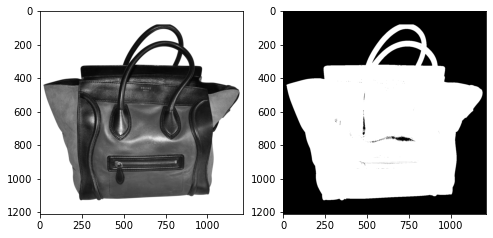

In [228]:
dir_path = 'glare_test/'
images = os.listdir(dir_path)
print(images)

img_path = os.path.join(dir_path+ images[0])
gray_img, mask, erosion, dilation = remove_glare(img_path)

fig=plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(gray_img,'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(mask,'gray')
plt.show()

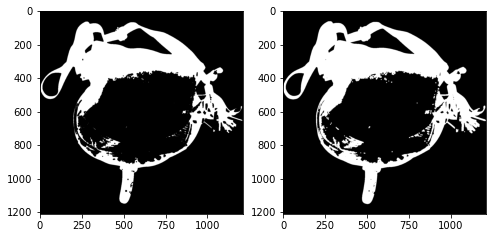

In [206]:
fig=plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(erosion,'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(dilation,'gray')
plt.show()

In [11]:
dir_path = 'glare_test/'
images = os.listdir(dir_path)
print(images)

img_path = os.path.join(dir_path+ images[2])

['2621282-1_1.jpg', '230222-1_1.jpg', '937347-1_1.jpg', '1027574-1_1.jpg', '173011-1_1.jpg']


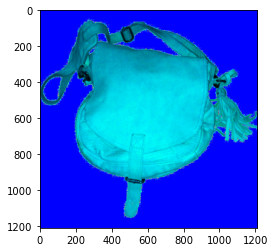

In [17]:
def mask_background(img):

    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    lower_white = np.array([254, 254, 254], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(img, lower_white, upper_white)  # could also use threshold
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))  # "erase" the small white points in the resulting mask
    mask = cv2.bitwise_not(mask)  # invert mask

    # load background (could be an image too)
    bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk

    # get masked foreground
    fg_masked = cv2.bitwise_and(img, img, mask=mask)

    return fg_masked


def create_mask(img):
    img = mask_background(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9,9), 0 )
    
    _,thresh_img = cv2.threshold( blurred, 180, 255, cv2.THRESH_BINARY)
    thresh_img = cv2.erode( thresh_img, None, iterations=1)
    thresh_img  = cv2.dilate( thresh_img, None, iterations=5)
    
    # perform a connected component analysis on the thresholded image,
    # then initialize a mask to store only the "large" components
    labels = measure.label( thresh_img, neighbors=8, background=0 )
    mask = np.zeros( thresh_img.shape, dtype="uint8" )
    
    for label in np.unique( labels ):
        if label == 0:
            continue
            
        # otherwise, construct the label mask and count the number of pixels
        labelMask = np.zeros( thresh_img.shape, dtype="uint8" )
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero( labelMask )
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 500:
            mask = cv2.add( mask, labelMask )
    return mask


def remove_using_hsv(img_path):
    frame = cv2.imread(img_path)

    rows = frame.shape[0]
    cols = frame.shape[1]

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    for i in range(0, cols):
        for j in range(0, rows):
            hsv[j, i][1] = 255;

    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return frame

    
    
mask = create_mask(img_path)
hsv_img = remove_using_hsv(img_path)
plt.imshow(hsv_img, )


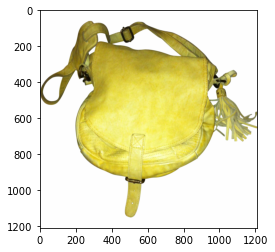

In [13]:
new_img = cv2.imread(img_path)
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB) 
plt.imshow(new_img)

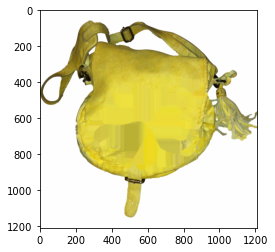

In [14]:
flag1 = cv2.INPAINT_NS
output = cv2.inpaint(new_img, mask, 3, flags=flag1)

plt.imshow(output)

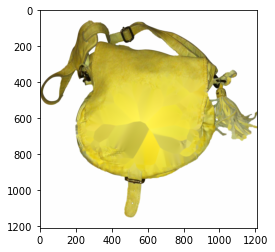

In [15]:
flag2 = cv2.INPAINT_TELEA
output = cv2.inpaint(new_img, mask, 4, flags=flag2)

plt.imshow(output)